# Convolutional Neural Network

<img src="http://deeplearning.stanford.edu/wiki/images/6/6c/Convolution_schematic.gif" alt="cnn structure image">

* __region feature__ : 이미지의 지역정보를 담은 영역. 이전의 flatten 한 데이터는 가까이 있는 값과 멀리 있는 값을 구분하지 못하였지만, region feature는 이미지를 flatten 하지 않고, 영역의 개념으로 가져옴으로써, 영역에서의 픽셀간의 거리를 고려할 수 있게 되었다.
* __receptive field__ : region feature를 추출하는 역할을 함. Receptive Field가 이미지를 순회하며 region feature를 포착한다.
* __stride__ : Convolutional layer에서 receptive field가 이동하는 칸 수를 의미
* __Padding__ : receptive field가 이미지를 순회 할때, 가장 자리 데이터를 더 적게 순회하게 된다. 이런 단점을 막기 위해, 이미지에 0 padding을 씌워 모든 이미지 픽셀 데이터가 동일한 횟수로 receptive field에 의해 인지되도록 하는 방법이다.
* __Weight Sharing__ : 더 적은 weight 수로 학습하기 위한 기법으로, 한 이미지에서 동일한 weight를 사용해 사용되는 weight의 수를 절약하는 방법이다. 예를 들면 Weight Sharing이 없을 경우에는 32 * 32 크기의 이미지를 5 * 5 receptive field로 1 stride씩 이동한다고 했을때, Feature map의 개수가 30개일 경우 $\text{# of weights} = (5\times 5) \times (28 \times 28 \times 30) = 588,000$개의 parameter가 필요하다. 이를 피하기 위해 receptive field가 지나갈때 마다 다른 weight로 feature 노드에 연결되는 것이 아니라, 동일한 weight로 feature에 연결하여 weight를 줄일 수 있다.
* __Pooling Layer__ : 
<img src="https://miro.medium.com/max/1304/1*Sh9e6Hzx8ZcOinuLvy8Fmw.png" alt="max pooling img">

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.functional import accuracy
from torchvision import transforms, datasets
from torchinfo import summary

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
train_dataset = datasets.CIFAR10(root="data/CIFAR_10", train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.CIFAR10(root="data/CIFAR_10", train=False, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified


In [5]:
for (X_train, y_train) in train_loader:
    print(f'X_train : {X_train.size()} type : {X_train.type()}')
    print(f'y_train : {y_train.size()} type : {y_train.type()}')
    break

X_train : torch.Size([32, 3, 32, 32]) type : torch.FloatTensor
y_train : torch.Size([32]) type : torch.LongTensor


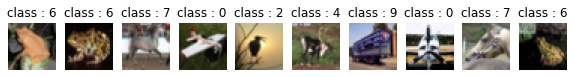

In [6]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis("off")
    plt.imshow(np.transpose(X_train[i], (1, 2, 0))) # [3, 32, 32] -> [32, 32, 3] : 사람이 볼 수 있는 형태로 변경.
    plt.title(f"class : {str(y_train[i].item())}")


In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=8,
            kernel_size=3,
            padding=1
        )
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=3,
            padding=1
        )
        self.pool = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
        
        self.fc1 = nn.Linear(16 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = x.view(-1, 16*16*16)
        
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        return x

In [9]:
model = CNN().to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(),lr = 1e-4)
criterion = nn.CrossEntropyLoss()

In [17]:
from torchsummary import summary

In [19]:
summary(model, (3, 32, 32), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [32, 8, 32, 32]             224
         MaxPool2d-2            [32, 8, 16, 16]               0
            Conv2d-3           [32, 16, 16, 16]           1,168
            Linear-4                   [32, 64]         262,208
            Linear-5                   [32, 32]           2,080
            Linear-6                   [32, 10]             330
Total params: 266,010
Trainable params: 266,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 3.53
Params size (MB): 1.01
Estimated Total Size (MB): 4.92
----------------------------------------------------------------


In [22]:
def train(model, train_loader, optimizer, log_interval, epoch):
    model.train()
    for batch_idx, (image, y) in enumerate(train_loader):
        image = image.to(DEVICE)
        y = y.to(DEVICE)
#         print(image.size())
        y_pred = model(image)
#         print(f"y_pred size : {y_pred.size()}")
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain loss: {:.6f}".format(
                    epoch,
                    batch_idx * len(image), 
                    len(train_loader.dataset), 
                    100 * batch_idx / len(train_loader), 
                    loss.item()
                )
            )
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    accuracies = []
    with torch.no_grad():
        for image, y in test_loader:
            image = image.to(DEVICE)
            y = y.to(DEVICE)
            y_pred = model(image)
            test_loss += criterion(y_pred, y).item()
            accuracies.append(accuracy(y_pred, y))
        test_loss /= len(test_loader.dataset)
        test_accuracy = torch.mean(torch.tensor(accuracies, device=DEVICE, requires_grad=False, dtype=torch.float32)) * 100.
    return test_loss, test_accuracy

In [23]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200, epoch=epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH]:{}], \tTest Loss: {:.4f}\t Test accuracy : {:.4f}%".format(epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000(0%)]	Train loss: 2.292219
Train Epoch: 1 [6400/50000(13%)]	Train loss: 2.222784
Train Epoch: 1 [12800/50000(26%)]	Train loss: 2.100101
Train Epoch: 1 [19200/50000(38%)]	Train loss: 2.071072
Train Epoch: 1 [25600/50000(51%)]	Train loss: 2.003689
Train Epoch: 1 [32000/50000(64%)]	Train loss: 1.877631
Train Epoch: 1 [38400/50000(77%)]	Train loss: 1.900654
Train Epoch: 1 [44800/50000(90%)]	Train loss: 1.767238

[EPOCH]:1], 	Test Loss: 0.0592	 Test accuracy : 32.3882%
Train Epoch: 2 [0/50000(0%)]	Train loss: 1.888336
Train Epoch: 2 [6400/50000(13%)]	Train loss: 1.869611
Train Epoch: 2 [12800/50000(26%)]	Train loss: 1.817019
Train Epoch: 2 [19200/50000(38%)]	Train loss: 2.015327
Train Epoch: 2 [25600/50000(51%)]	Train loss: 1.824427
Train Epoch: 2 [32000/50000(64%)]	Train loss: 1.850472
Train Epoch: 2 [38400/50000(77%)]	Train loss: 1.952686
Train Epoch: 2 [44800/50000(90%)]	Train loss: 1.659052

[EPOCH]:2], 	Test Loss: 0.0528	 Test accuracy : 38.6781%
Train Epoch: 3 [

# Pretrained model을 불러와 학습

pytorch에서 제공하는 reference 모델을 불러와 분류를 시도해 보자.

In [25]:
import torchvision.models as models

In [26]:
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(DEVICE)

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 3
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200, epoch=epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH]:{}], \tTest Loss: {:.4f}\t Test accuracy : {:.4f}%".format(epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000(0%)]	Train loss: 2.797476
Train Epoch: 1 [6400/50000(13%)]	Train loss: 1.636038
Train Epoch: 1 [12800/50000(26%)]	Train loss: 1.595080
Train Epoch: 1 [19200/50000(38%)]	Train loss: 0.765296
Train Epoch: 1 [25600/50000(51%)]	Train loss: 0.716633
Train Epoch: 1 [32000/50000(64%)]	Train loss: 1.136869
Train Epoch: 1 [38400/50000(77%)]	Train loss: 1.036223
Train Epoch: 1 [44800/50000(90%)]	Train loss: 0.698290

[EPOCH]:1], 	Test Loss: 0.0294	 Test accuracy : 69.0994%
Train Epoch: 2 [0/50000(0%)]	Train loss: 0.800992
Train Epoch: 2 [6400/50000(13%)]	Train loss: 0.801656
Train Epoch: 2 [12800/50000(26%)]	Train loss: 0.885624
Train Epoch: 2 [19200/50000(38%)]	Train loss: 0.749983
Train Epoch: 2 [25600/50000(51%)]	Train loss: 0.632234
Train Epoch: 2 [32000/50000(64%)]	Train loss: 0.525370
Train Epoch: 2 [38400/50000(77%)]	Train loss: 1.277532
Train Epoch: 2 [44800/50000(90%)]	Train loss: 0.573264

[EPOCH]:2], 	Test Loss: 0.0259	 Test accuracy : 72.7536%
Train Epoch: 3 [

# AlexNet

AlexNet은 인공지능의 classification 대회인 ILSVRC(2012)에서 우승한 모델이다. AlexNet이 CIFAR-10 데이터셋을 얼마나 잘 구분하는지, pytorch를 이용해 구현해 확인해 보자.

AlexNet의 architecture는 아래의 그림과 같다.

![](https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fy7C1J%2FbtqUBvS4iPF%2Frf87FMhz6hGtcXwNmW755k%2Fimg.png)

그림과 같이 AlexNet은 2개의 GPU에 연산을 할당하여 병렬 처리 할 수 있는 구조로 되어 있지만, 여기서는 병렬처리는 하지 않고 하나의 pipeline만을 사용하여 구현하는 것을 목표로 한다.

먼저 AlexNet에서 사용한 이미지 데이터의 크기는 224 x 224 크기이다. 하지만 우리의 데이터셋의 크기는 32 * 32 임으로 그에 맞추어 연산을 수행하도록 조정한다.

Alex는 총 8개의 layer로 구성되어 있다.

앞의 5개의 layer는 CNN이고 나머지 3개는 fully connected layer이다. 논문에서 사용한 데이터의 분류 개수는 1000개이지만 여기서는 10개의 클래스밖에 없음으로 10으로 한다.



Convolution Layer의 output size 계산법

$$O = \frac {I - K + 2P}{S} + 1$$

MaxPool2D의 output size 계산법

$$out(Batch, Channel, h, w) = \underset{m =0,...,Kernel * H-1}{max} \underset{n =0,...,Kernel * W-1}{max} input(Batch, Channel, stride[0] \times h + m, stride[1] \times w + n)$$



In [28]:
class AlexNetModule(nn.Module):
    def __init__(self):
        super(AlexNetModule, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=96,
                kernel_size=3,
                stride=1,
                padding='valid'
            ),
            ## (32 - 3 + 0) / 1 + 1 = 29 -> [96, 30, 30]
            nn.ReLU(),
            nn.BatchNorm2d(num_features=96),
            nn.MaxPool2d(kernel_size=(2,2)), ## [96, 15, 15] 2 * h,w + 1 = 15 -> h,w = 7
            nn.Conv2d(
                in_channels=96,
                out_channels=256,
                kernel_size=5,
                padding="same"
            ), # [256, 15, 15]
            nn.ReLU(),
            nn.BatchNorm2d(num_features=256),
            nn.MaxPool2d(kernel_size=(2,2)), # [256, 7, 7]
            nn.Conv2d(
                in_channels=256,
                out_channels=384,
                kernel_size=2,
                padding="same"
            ),
            # [384, 7, 7]
            nn.ReLU(),
            nn.BatchNorm2d(384),
            nn.Conv2d(
                in_channels=384,
                out_channels=384,
                kernel_size=2,
                padding="same"
            ),
            # [384, 7, 7]
            nn.ReLU(),
            nn.BatchNorm2d(384),
            nn.Conv2d(
                in_channels=384,
                out_channels=256,
                kernel_size=2,
                padding="same"
            ),
            # [384, 7, 7]
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=(2,2)), # [256 ,3, 3] 2 * h,w + 1 = 7 -> h, w = 3
            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 4096),
            nn.ReLU(),
            nn.BatchNorm1d(4096),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.BatchNorm1d(4096),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.model(x)

        return x

In [29]:
model = AlexNetModule().to(DEVICE)

In [30]:
summary(model, input_size=(3,32,32),batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 96, 30, 30]           2,688
              ReLU-2           [32, 96, 30, 30]               0
       BatchNorm2d-3           [32, 96, 30, 30]             192
         MaxPool2d-4           [32, 96, 15, 15]               0
            Conv2d-5          [32, 256, 15, 15]         614,656
              ReLU-6          [32, 256, 15, 15]               0
       BatchNorm2d-7          [32, 256, 15, 15]             512
         MaxPool2d-8            [32, 256, 7, 7]               0
            Conv2d-9            [32, 384, 7, 7]         393,600
             ReLU-10            [32, 384, 7, 7]               0
      BatchNorm2d-11            [32, 384, 7, 7]             768
           Conv2d-12            [32, 384, 7, 7]         590,208
             ReLU-13            [32, 384, 7, 7]               0
      BatchNorm2d-14            [32, 38

/root/anaconda3/envs/transformer/lib/python3.9/site-packages/torch/nn/modules/conv.py:442: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811803361/work/aten/src/ATen/native/Convolution.cpp:647.)
  return F.conv2d(input, weight, bias, self.stride,


In [31]:
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-4)
criterion = nn.CrossEntropyLoss()

EPOCHS = 6
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200, epoch=epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH]:{}], \tTest Loss: {:.4f}\t Test accuracy : {:.4f}%".format(epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000(0%)]	Train loss: 2.594068
Train Epoch: 1 [6400/50000(13%)]	Train loss: 1.920596
Train Epoch: 1 [12800/50000(26%)]	Train loss: 1.305031
Train Epoch: 1 [19200/50000(38%)]	Train loss: 1.477013
Train Epoch: 1 [25600/50000(51%)]	Train loss: 1.180894
Train Epoch: 1 [32000/50000(64%)]	Train loss: 1.338906
Train Epoch: 1 [38400/50000(77%)]	Train loss: 1.341099
Train Epoch: 1 [44800/50000(90%)]	Train loss: 1.276514

[EPOCH]:1], 	Test Loss: 0.0330	 Test accuracy : 62.4301%
Train Epoch: 2 [0/50000(0%)]	Train loss: 1.087142
Train Epoch: 2 [6400/50000(13%)]	Train loss: 0.942557
Train Epoch: 2 [12800/50000(26%)]	Train loss: 1.171911
Train Epoch: 2 [19200/50000(38%)]	Train loss: 1.094130
Train Epoch: 2 [25600/50000(51%)]	Train loss: 1.139773
Train Epoch: 2 [32000/50000(64%)]	Train loss: 1.145204
Train Epoch: 2 [38400/50000(77%)]	Train loss: 1.043927
Train Epoch: 2 [44800/50000(90%)]	Train loss: 0.614718

[EPOCH]:2], 	Test Loss: 0.0285	 Test accuracy : 68.4006%
Train Epoch: 3 [